In [5]:
!pip install geopandas

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 141.3 kB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.5/16.5 MB 142.0 kB/s eta 0:00:0000:0100:04
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 165.1 kB/s eta 0:00:0000:0100:02
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 145.7 kB/s eta 0:00:0000:0100:01


In [31]:
import os, folium, glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

import imageio.v3 as iio
import geopandas as gpd
from IPython.display import Image, display
from tensorflow.keras.utils import image_dataset_from_directory
%matplotlib inline

In [7]:
from tensorflow.keras import layers, callbacks, backend, Model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer

## Download features and labels

In [12]:
labels = gpd.read_file('labels.geojson')
labels.head(2)

,id,Latitude,Longitude,Type,Source,Image_Folder,geometry
0,1,43.004434,-78.208900,Negative,Aeroplanes,train_images/43.00443446102501_-78.20890003579709,"POLYGON ((-78.20567 43.00681, -78.20567 43.002..."
1,6,42.033642,-97.719996,Negative,"White Spec (Seadoo, pivot irrigation, etc.)",train_images/42.03364226519898_-97.7199955063882,"POLYGON ((-97.71676 42.03605, -97.71676 42.031..."


In [13]:
labels.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 14187 entries, 0 to 14186
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   id            14187 non-null  object  
 1   Latitude      14187 non-null  float64 
 2   Longitude     14187 non-null  float64 
 3   Type          14187 non-null  object  
 4   Source        14187 non-null  object  
 5   Image_Folder  14187 non-null  object  
 6   geometry      14187 non-null  geometry
dtypes: float64(2), geometry(1), object(4)
memory usage: 776.0+ KB


In [14]:
labels.Type.value_counts()

Negative                                        5785
CAFOs                                           4096
WWTreatment                                     2409
Landfills                                        677
RefineriesAndTerminals                           608
ProcessingPlants                                 278
Mines                                            273
WWTreatment-RefineriesAndTerminals                19
WWTreatment-Landfills                              9
RefineriesAndTerminals-ProcessingPlants            9
Mines-Landfills                                    6
RefineriesAndTerminals-Landfills                   4
CAFOs-WWTreatment                                  3
CAFOs-Landfills                                    2
WWTreatment-Mines                                  2
WWTreatment-ProcessingPlants                       2
ProcessingPlants-Landfills                         2
WWTreatment-RefineriesAndTerminals-Landfills       1
Mines-ProcessingPlants                        

Largely imbalanced dataset.<br>
Start baseline analysis with pure labels.<br>
Work on combined labels afterwards.

In [15]:
labels_unique = labels[(labels.Type == 'Negative') | (labels.Type == 'CAFOs') | (labels.Type == 'WWTreatment')
           | (labels.Type == 'Landfills') | (labels.Type == 'RefineriesAndTerminals')
           | (labels.Type == 'ProcessingPlants') | (labels.Type == 'Mines')]

In [18]:
labels_unique

,id,Latitude,Longitude,Type,Source,Image_Folder,geometry
0,1,43.004434,-78.208900,Negative,Aeroplanes,train_images/43.00443446102501_-78.20890003579709,"POLYGON ((-78.20567 43.00681, -78.20567 43.002..."
1,6,42.033642,-97.719996,Negative,"White Spec (Seadoo, pivot irrigation, etc.)",train_images/42.03364226519898_-97.7199955063882,"POLYGON ((-97.71676 42.03605, -97.71676 42.031..."
2,9,34.495000,-97.118000,WWTreatment,HydroWASTE,train_images/34.495_-97.118,"POLYGON ((-97.11477 34.49768, -97.11477 34.492..."
3,12,38.381380,-75.401000,CAFOs,DataForCauseChallenge,train_images/38.38138_-75.401,"POLYGON ((-75.39777 38.38393, -75.39777 38.378..."
4,17,45.647973,-84.469159,RefineriesAndTerminals,EIA-HIFLD,train_images/45.647973_-84.469159,"POLYGON ((-84.46593 45.65024, -84.46593 45.645..."
...,...,...,...,...,...,...,...
14182,84941,35.852756,-101.538265,Negative,Windmills,train_images/35.85275555452138_-101.5382646083...,"POLYGON ((-101.53503 35.85539, -101.53503 35.8..."
14183,85008,47.186826,-122.436115,Negative,Roundabout,train_images/47.18682636726484_-122.4361145478...,"POLYGON ((-122.43288 47.18903, -122.43288 47.1..."
14184,85035,42.703517,-83.303270,Negative,Parking Lots,train_images/42.703517482995565_-83.3032698788...,"POLYGON ((-83.30004 42.70590, -83.30004 42.701..."
14185,85048,34.159700,-86.468760,CAFOs,DataForCauseChallenge,train_images/34.1597_-86.46876,"POLYGON ((-86.46553 34.16239, -86.46553 34.157..."


In [ ]:
os.listdir()

In [22]:
X = []
for im_path in os.listdir('train_images'):
     X.append(iio.imread(f'train_images/{im_path}/naip.png'))

## Inspect labels and visualize some images

In [23]:
len(X)

21

In [24]:
X[0].shape

(720, 720, 4)

IndexError: list index out of range

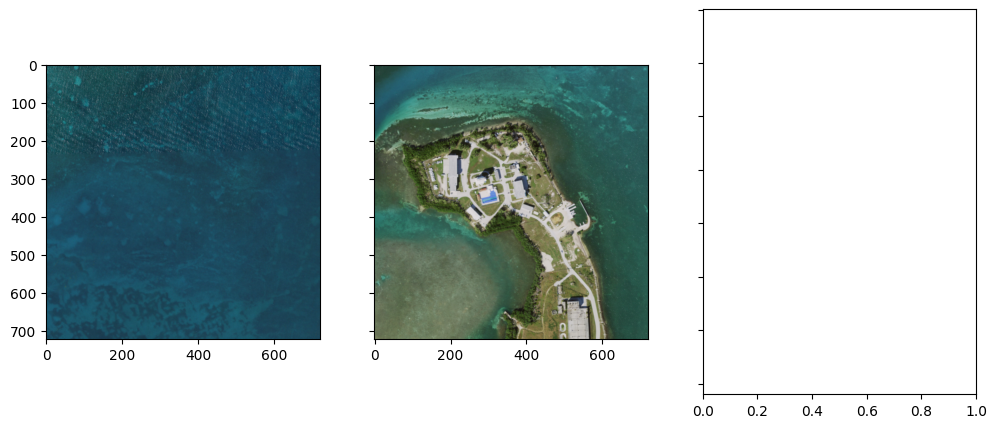

In [25]:
# RGB Image of 3 samples
fig, axs = plt.subplots(1, 3, sharey=True, figsize=(12,5))
axs[0].imshow(X[0][:,:,:3])
axs[1].imshow(X[10][:,:,:3])
axs[2].imshow(X[1000][:,:,:3])

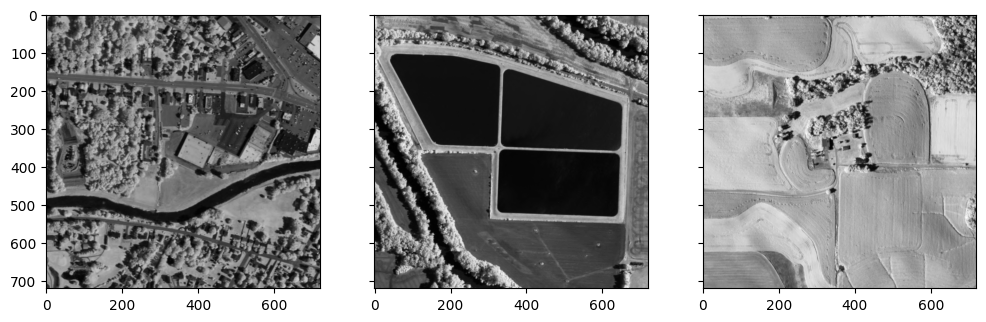

In [12]:
# NIR image of 3 samples
fig, axs = plt.subplots(1, 3, sharey=True, figsize=(12,5))
axs[0].imshow(X[0][:,:,-1], cmap='gray')
axs[1].imshow(X[10][:,:,-1], cmap='gray')
axs[2].imshow(X[1000][:,:,-1], cmap='gray')

In [13]:
# Label of the 3 selected samples
df_temp = labels_unique.iloc[[0]].copy()
df_temp.loc[1] = labels_unique.iloc[10].copy()
df_temp.loc[2] = labels_unique.iloc[1000].copy()
df_temp

,id,Latitude,Longitude,Type,Source,Image_Folder,geometry
0,1,43.004434,-78.20890,Negative,Aeroplanes,train_images/43.00443446102501_-78.20890003579709,"POLYGON ((-78.20567 43.00681, -78.20567 43.002..."
1,29,37.409000,-95.66900,WWTreatment,HydroWASTE,train_images/37.409_-95.669,"POLYGON ((-95.66577 37.41158, -95.66577 37.406..."
2,3881,44.496805,-92.68644,CAFOs,MinnesotaPollutionControlAgency,train_images/44.49680485_-92.68644007,"POLYGON ((-92.68321 44.49912, -92.68321 44.494..."


In [3]:
m = folium.Map([labels_unique.Latitude.min(), labels_unique.Longitude.min()], zoom_start=5, tiles='cartodbpositron')
folium.GeoJson(labels_unique.geometry.iloc[0:1000]).add_to(m)
#m

NameError: name 'labels_unique' is not defined

## Select X, y and do train / val / test split

In [26]:
categories = list(set(labels_unique.Type.values))
categories
#labels_unique.Type.value_counts()

['Mines',
 'ProcessingPlants',
 'RefineriesAndTerminals',
 'Landfills',
 'WWTreatment',
 'Negative',
 'CAFOs']

In [ ]:
#onehot_layer = layers.StringLookup(output_mode='multi_hot')
#onehot_layer.adapt(labels_unique.Type.values)
#onehot_layer.get_vocabulary()
#y = onehot_layer(labels_unique.Type.values.reshape(100,1)).numpy()

In [27]:
labels_unique.Type.values.shape

(14126,)

In [28]:
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(labels_unique.Type.values.reshape(labels_unique.Type.values.shape[0], 1))
mlb.classes_

array(['CAFOs', 'Landfills', 'Mines', 'Negative', 'ProcessingPlants',
       'RefineriesAndTerminals', 'WWTreatment'], dtype=object)

In [18]:
X_train, X_rest, y_train, y_rest = train_test_split(X, y, train_size=0.7, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_rest, y_rest, train_size=0.5, stratify=y_rest)


In [29]:
type(X)

list

In [32]:
X_pipe = tf.data.Dataset.from_tensor_slices(X)
X_pipe

2023-05-22 16:45:04.052967: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-22 16:45:04.059211: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-05-22 16:45:04.059339: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2023-05-22 16:45:04.059409: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2023-05-22 16:45:04.059476: W tensorflow/stream_executor/platform/default/dso_loader.cc:6

<TensorSliceDataset element_spec=TensorSpec(shape=(720, 720, 4), dtype=tf.uint8, name=None)>

In [39]:
iterator = iter(X_pipe)
first_element = next(iterator)
shape = first_element.shape
print(shape)

(720, 720, 4)


Check that stratification worked

In [19]:
np.sum(y_train, axis=0)/np.sum(y_train)

array([0.28994741, 0.04793689, 0.01931634, 0.40948625, 0.01972087,
       0.04308252, 0.17050971])

In [20]:
np.sum(y_rest, axis=0)/np.sum(y_rest)

array([0.28999528, 0.04789995, 0.01934875, 0.40962718, 0.01958471,
       0.04294479, 0.17059934])

In [ ]:
def invert_ecoding(encoded_labels, categories):
    categories = ['[unk]']+categories
    return np.take(categories, np.argwhere(encoded_labels == 1.0)[:,1])

In [22]:
y_tra_orig = np.argwhere(y_train == 1.0)[:,1]
y_res_orig = np.argwhere(y_rest == 1.0)[:,1]

(array([1229.,    0.,    0.,  203.,    0.,    0.,   82.,    0.,    0.,
           0., 1736.,    0.,    0.,   83.,    0.,    0.,  182.,    0.,
           0.,  723.]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. , 3.3, 3.6,
        3.9, 4.2, 4.5, 4.8, 5.1, 5.4, 5.7, 6. ]),
 <BarContainer object of 20 artists>)

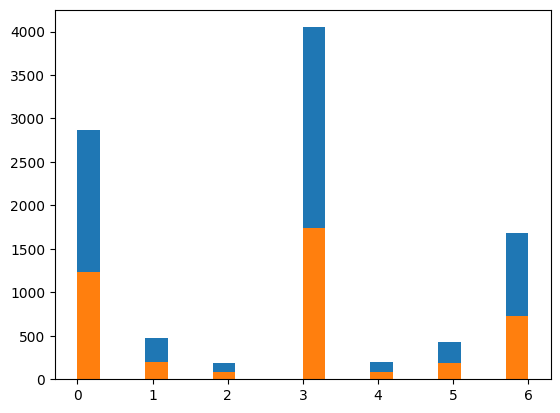

In [23]:
plt.hist(y_tra_orig, bins=20)
plt.hist(y_res_orig, bins=20)

## Initial Model

Add normalization for the X data (divide by 255.)

In [ ]:
def build_model():
    
    inputs = layers.Input(shape=(720,720, 4))
    out = layers.Conv2D(16, (2,2), activation='relu', padding='same')(inputs)
    out = layers.MaxPool2D()(out)
    out = layers.Conv2D(32, (2,2), activation='relu', padding='same')(out)
    out = layers.MaxPool2D()(out)
    out = layers.Conv2D(64, (2,2), activation='relu', padding='same')(out)
    out = layers.MaxPool2D()(out)
    out = layers.Conv2D(64, (2,2), activation='relu', padding='same')(out)
    out = layers.Flatten()(out)
    out = layers.Dense(32, activation='relu')(out)
    out = layers.Dense(6, activation='sigmoid')(out)
    model = Model(inputs=inputs, outputs=out)
    
    model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy",
                                                                         "precision",
                                                                         "recall"])
    return model

In [ ]:
backend.clear_session()
model = build_model()
model.summary()

In [ ]:
cb = [callbacks.EarlyStopping(patience=5), callbacks.ReduceLROnPlateau(patience=3)]
epochs = 10
batch_size = 4

history = model.fit(X_train,
         y_train,
         epochs=epochs,
         batch_size=batch_size,
         callbacks=cb,
         validation_data=(X_val, y_val))


In [ ]:
y_pred = model.predict(X_test)
y_pred[y_pred >= 0.5] = 1
y_pred[y_pred < 0.5] = 0

# score between y_test and y_pred